In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

import tensorflow as tf
from tensorflow.python.framework import ops

from keras.datasets import cifar10
from keras.utils import to_categorical

%matplotlib inline
np.random.seed(1)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
X_train = x_train/255.
X_test = x_test/255.

Y_train = to_categorical(y_train, 10)
Y_test = to_categorical(y_test, 10)

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 50000
number of test examples = 10000
X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 10)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 10)


In [4]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    
    m = X.shape[0]
    mini_batches = []
    np.random.seed(seed)
    
    # Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [5]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    placeholders for the tensorflow session.
    
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
    """
    print("Creating Place holder\n")
    X = tf.placeholder(tf.float32, shape = (None, n_H0, n_W0, n_C0))
    Y = tf.placeholder(tf.float32, shape = (None, n_y))
    print("Done Creating Place holder!\n")
    
    return X, Y

In [6]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [3, 3, 8, 8]
                        W3 : [2, 2, 8, 16]
    """
    print("Initializing Parameters\n")
    
    tf.set_random_seed(1)
    W1 = tf.get_variable("W1",[4,4,3,8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2",[3,3,8,8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W3 = tf.get_variable("W3",[2,2,8,16],initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    
    print("Done Initializing Parameters!\n")
    
    parameters = {"W1": W1,
                  "W2": W2,
                  "W3": W3}
    
    return parameters

In [7]:
def forward_propagation(X, parameters):
    """
    CONV2D -> POOL -> RELU -> NORM -> CONV2D -> RELU -> POOL -> CONV2D -> RELU -> POOL -> IP
    
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    # MAXPOOL: window 2x2, sride 2, padding 'SAME'
    P1 = tf.nn.max_pool(Z1 , ksize=[1,2,2,1] , strides = [1,2,2,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(P1)
    #Normalization Layer
    N1 = tf.contrib.layers.batch_norm(A1)
    
    #CONV2D: stride of 1, padding 'SAME'
    Z2 = tf.nn.conv2d(N1,W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 2x2, sride 2, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize=[1,2,2,1] , strides = [1,2,2,1], padding = 'SAME')
    
    # CONV2D: stride of 1, padding 'SAME'
    Z3 = tf.nn.conv2d(P2, W3, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A3 = tf.nn.relu(Z3)
    # MAXPOOL: window 2x2, sride 2, padding 'SAME'
    P3 = tf.nn.max_pool(A3 , ksize=[1,2,2,1] , strides = [1,2,2,1], padding = 'SAME')
    
    
    # FLATTEN
    P3 = tf.contrib.layers.flatten(P3)
    # FULLY-CONNECTED without non-linear activation function
    Z3 = tf.contrib.layers.fully_connected(P3,num_outputs=10,activation_fn=None)

    return Z3

In [8]:
def compute_cost(Z3, Y):
    
    #Computes the cost
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=Y))
    
    return cost

In [9]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001,
          num_epochs = 140, minibatch_size = 100, print_cost = True):
    """
    CONV2D -> POOL -> RELU -> NORM -> CONV2D -> RELU -> POOL -> CONV2D -> RELU -> POOL -> IP
    
    """
    
    # to be able to rerun the model without overwriting tf variables
    ops.reset_default_graph()
    # to keep results consistent (tensorflow seed)
    tf.set_random_seed(1) 
    # to keep results consistent (numpy seed)
    seed = 3
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    # To keep track of the cost
    costs = []
    
    # Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0,n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    #regularizer1 = tf.nn.l2_loss(parameters["W1"])
    #regularizer2 = tf.nn.l2_loss(parameters["W2"])
    #cost = tf.reduce_mean(cost + 0.01 * (regularizer1) )
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
                
                _ , temp_cost = sess.run([optimizer,cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 10 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Creating Place holder

Done Creating Place holder!

Initializing Parameters

Done Initializing Parameters!

Cost after epoch 0: 1.798455
Cost after epoch 10: 1.113491
Cost after epoch 20: 1.036431
Cost after epoch 30: 1.000611
Cost after epoch 40: 0.987738
Cost after epoch 50: 0.966251
Cost after epoch 60: 0.954875
Cost after epoch 70: 0.945174
Cost after epoch 80: 0.933073
Cost after epoch 90: 0.925339
Cost after epoch 100: 0.919166
Cost after epoch 110: 0.911415
Cost after epoch 120: 0.901435
Cost after epoch 130: 0.898825


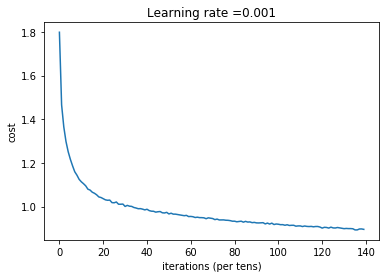

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.69298
Test Accuracy: 0.6521


In [10]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)